<a href="https://colab.research.google.com/github/gaurangdave/mnist_object_detection/blob/main/notebooks/03_google_colab_migration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/gaurangdave/mnist_object_detection/blob/main/notebooks/03_google_colab_migration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Object Detection

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.datasets import fetch_openml
from keras.datasets import mnist


import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
import PIL.Image
from matplotlib import patches



In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Data Access

## Set Constants  

In [3]:
data_dir = Path("data")
models_dir = Path("models")

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

# Data Generation

In [6]:
ALL_MNIST_DATA_PIXELS = x_train
ALL_MNIST_DATA_CLASSES = y_train

# number of digits to overlay on canvas
num_of_digits = 2

# max digits to define the shape of prediction output
MAX_DIGITS = 5


# Sample Base Digits
def get_sample_indices(dataset, size=5):
  random_indices = np.random.choice(len(dataset), size=size, replace=False)
  return random_indices

# helper function to sample number of digits from master dataset
def sample_base_digits(num_of_digits):
    """
    Sample a specified number of digit images and their class labels from the master MNIST dataset.

    Args:
        num_of_digits (int): Number of digit samples to retrieve.

    Returns:
        tuple: (sample_pixels, sample_values)
            sample_pixels (np.ndarray): Array of digit images with shape (num_of_digits, 28, 28, 1).
            sample_values (np.ndarray): Array of class labels with shape (num_of_digits, 1).
    """
    sample_indices = get_sample_indices(ALL_MNIST_DATA_PIXELS, size=num_of_digits)
    sample_pixels = ALL_MNIST_DATA_PIXELS[sample_indices]
    sample_pixels = sample_pixels.reshape(-1,28,28,1)

    sample_values = ALL_MNIST_DATA_CLASSES[sample_indices]
    sample_values = sample_values.reshape(-1, 1)

    # split the digits into pixels and class values
    # reshape the data to expected values
    # sample_pixels = sample.drop(
    #     columns=["class"]).to_numpy().reshape(-1, 28, 28, 1)
    # sample_values = sample["class"].values.reshape(-1, 1)
    return sample_pixels, sample_values
# Augment Digits


def plot_before_after(before_image, after_image):
    """
    Display two images side by side for visual comparison (e.g., before and after augmentation).

    Args:
        before_image (np.ndarray): The original image.
        after_image (np.ndarray): The image after transformation or augmentation.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    axs = axs.ravel()
    axs[0].imshow(before_image)
    axs[1].imshow(after_image)

    plt.axis("off")  # Remove axes for better visualization
    plt.show()
# helper function to apply random augmentation to digits


def augment_digits(digits, debug=False):
    """
    Apply random augmentations (translation, zoom, rotation) to a batch of digit images.

    Args:
        digits (np.ndarray): Array of digit images to augment.
        debug (bool, optional): If True, displays before/after images for each digit. Defaults to False.

    Returns:
        np.ndarray: Augmented digit images as a numpy array.
    """
    tensor_digits = tf.convert_to_tensor(digits)

    # step 2: apply random augmentation
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomTranslation(
            height_factor=0.2, width_factor=0.2, fill_value=0.0, fill_mode="constant", seed=42),

        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2, fill_value=0.0, fill_mode="constant", seed=42),

        tf.keras.layers.RandomRotation(
            factor=0.1, fill_value=0.0, fill_mode="constant", seed=42),
    ])
    augmented_tensor_digits = augmentation(tensor_digits)

    # if debug is true render before digits
    if debug == True:
        for translated_imgs in range(tensor_digits.shape[0]):
            plot_before_after(
                tensor_digits[translated_imgs], augmented_tensor_digits[translated_imgs])

    # convert the tensor back to numpy to simplify use in map function
    return augmented_tensor_digits.numpy()
# Calculate Tight BBox
# helper function to calculate bounding box for each instance and return it.
# we are going to refactor the POC that we created ealier to use it with numpy arrays in the map function


def calculate_bounding_box(pixels, class_value, padding=1):
    """
    Calculate the tight bounding box for a digit image and return its coordinates and class value.

    Args:
        pixels (np.ndarray): 2D array representing the digit image.
        class_value (int): The class label of the digit.
        padding (int, optional): Padding to add around the bounding box. Defaults to 1.

    Returns:
        dict: Bounding box information including coordinates, center, width, height, and class value.
    """
    # calculate active rows & columns
    active_rows = np.sum(pixels, axis=1)
    active_columns = np.sum(pixels, axis=0)

    # calculate x_min and x_max coordinate
    x_min = np.nonzero(active_columns)[0][0]
    x_max = np.nonzero(active_columns)[0][-1]
    y_min = np.nonzero(active_rows)[0][0]
    y_max = np.nonzero(active_rows)[0][-1]

    # add padding to pixels
    x_min = x_min - (padding if (x_min != 0) else 0)
    x_max = x_max + (padding if (x_max != 27) else 0)
    y_min = y_min - (padding if (y_min != 0) else 0)
    y_max = y_max + (padding if (y_max != 27) else 0)

    # calcualte x_center and y_center
    x_center = round((x_min + x_max) / 2)
    y_center = round((y_min + y_max) / 2)

    # calculate width and height
    width = x_max - x_min + 1
    height = y_max - y_min + 1

    return {
        "x_min": x_min,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "x_center": x_center,
        "y_center": y_center,
        "width": width,
        "height": height,
        "class_value": class_value
    }


# helper function to visualize the bounding box


def visualize_bounding_box(pixel_data, bounding_boxes, num_of_columns=5):
    """
    Visualize digit images with their corresponding bounding boxes.

    Args:
        pixel_data (np.ndarray): Array of digit images.
        bounding_boxes (list): List of bounding box dictionaries for each digit.
        num_of_columns (int, optional): Number of columns in the plot grid. Defaults to 5.
    """
    num_of_columns = num_of_columns if num_of_columns <= 5 else 5
    num_instances = pixel_data.shape[0]
    num_of_rows = int(num_instances / num_of_columns) + \
        (1 if int(num_instances % num_of_columns) > 0 else 0)

    fig, axs = plt.subplots(num_of_rows, num_of_columns, figsize=(10, 3))
    axs = axs.ravel()

    for idx in range(0, num_instances, 1):

        original = tf.constant(pixel_data[idx].reshape(28, 28, 1))
        converted = tf.image.grayscale_to_rgb(original)
        target_data = bounding_boxes[idx]
        x_center = target_data["x_center"]
        y_center = target_data["y_center"]
        width = target_data["width"]
        height = target_data["height"]

        x = target_data["x_min"]
        y = target_data["y_min"]

        rect = patches.Rectangle(
            (x, y), width=width, height=height, linewidth=1, edgecolor='r', facecolor='none')
        image_data = converted.numpy().astype("uint8")
        axs[idx].imshow(image_data)
        axs[idx].add_patch(rect)

        axs[idx].set_title(target_data["class_value"])
        axs[idx].axis("off")
    plt.show()
# helper function to calculate bounding box for digits.


def calculate_tight_bbox(pixels, class_values, debug=False):
    """
    Calculate tight bounding boxes for a batch of digit images.

    Args:
        pixels (np.ndarray): Array of digit images.
        class_values (np.ndarray): Array of class labels for each digit.
        debug (bool, optional): If True, visualizes the bounding boxes. Defaults to False.

    Returns:
        list: List of bounding box dictionaries for each digit.
    """
    class_with_bbox = []
    for idx in range(pixels.shape[0]):
        class_with_bbox.append(calculate_bounding_box(
            pixels[idx], class_values[idx][0]))

    # if debug true render digits with bbox
    if debug == True:
        visualize_bounding_box(pixels, class_with_bbox, pixels.shape[0])

    return class_with_bbox
# Create Blank Canvas
# helper function to create  blank canvas


def create_blank_canvas(shape=(100, 100, 1)):
    """
    Create a blank canvas for placing digit images.

    Args:
        shape (tuple, optional): Shape of the canvas. Defaults to (100, 100, 1).

    Returns:
        np.ndarray: Blank canvas array.
    """
    canvas = np.zeros(shape=(100, 100, 1), dtype=np.float32)
    return canvas
# Create Prediction Object
# helper function to create empty predition structure based on MAX_DIGITS


def create_prediction_object():
    """
    Create an empty prediction object for storing digit detection results.

    Returns:
        np.ndarray: Prediction array of shape (MAX_DIGITS, 15).
    """
    prediction = np.zeros(shape=(MAX_DIGITS, 15), dtype=np.float32)
    return prediction
# Place Digit On Canvas


def is_valid_coordinates(top, left, class_bbox_value, existing_coordinates):
    """
    Check if the proposed top-left coordinates for a digit's bounding box are valid (within canvas and non-overlapping).

    Args:
        top (int): Proposed top coordinate.
        left (int): Proposed left coordinate.
        class_bbox_value (dict): Bounding box info for the digit.
        existing_coordinates (list): List of existing bounding boxes on the canvas.

    Returns:
        bool: True if coordinates are valid, False otherwise.
    """
    # # make sure the top and left are withing the canvas
    # if (top + 28 >= 100 or left + 28 >= 100):
    #     return False
    # read current class values
    # curr_x_center = class_bbox_value["x_center"]
    # curr_y_center = class_bbox_value["y_center"]
    curr_width = class_bbox_value["width"]
    curr_height = class_bbox_value["height"]
    curr_x_min = left
    curr_y_min = top
    curr_x_max = left + curr_width
    curr_y_max = top + curr_height

    # recalculate center with proposed top and left values
    # curr_x_center = curr_x_center + left
    # curr_y_center = curr_y_center + top

    # check 1: will the new bounding box go beyond the grid?
    if ((curr_x_min + curr_width) >= 100) or ((curr_y_min + curr_height) >= 100):
        return False

    # check 2: do bounding boxes overlap
    # check the current bounding box with every existing box
    for coord_idx in range(len(existing_coordinates)):
        existing_x_min = existing_coordinates[coord_idx]["x_min"]
        existing_y_min = existing_coordinates[coord_idx]["y_min"]
        existing_x_max = existing_coordinates[coord_idx]["x_max"]
        existing_y_max = existing_coordinates[coord_idx]["y_max"]
        if ((curr_x_min <= existing_x_max and curr_x_max >= existing_x_min) and (curr_y_min <= existing_y_max and curr_y_max >= existing_y_min)):
            return False

    return True


def select_top_left(class_bbox_value, existing_coordinates):
    """
    Randomly select valid top-left coordinates for placing a digit on the canvas.

    Args:
        class_bbox_value (dict): Bounding box info for the digit.
        existing_coordinates (list): List of existing bounding boxes on the canvas.

    Returns:
        tuple: (top, left) coordinates if valid, otherwise (-1, -1).
    """
    got_valid_coordinates = False
    # limiting the loop to run only 20 times
    retries = 0
    while ((not got_valid_coordinates) and (retries < 50)):
        top = np.random.randint(0, high=100)
        left = np.random.randint(0, high=100)
        got_valid_coordinates = is_valid_coordinates(
            top, left, class_bbox_value, existing_coordinates)
        retries = retries+1

    if got_valid_coordinates:
        return top, left
    return -1, -1


# helper function to render the canvas
# update the original plotting function to plot canvas as well.


def render_canvas(canvas, class_bbox):
    """
    Render the canvas with all placed digits and their bounding boxes.

    Args:
        canvas (np.ndarray): The canvas image.
        class_bbox (list): List of bounding box dictionaries for each digit.
    """
    num_of_digits = len(class_bbox)
    fig, axs = plt.subplots(1, 1, figsize=(10, 3))
    axs.imshow(canvas)  # Use 'gray' colormap to render grayscale
    axs.axis("off")

    for idx in range(0, num_of_digits, 1):
        width = class_bbox[idx]["width"]
        height = class_bbox[idx]["height"]

        x = class_bbox[idx]["x_min"]
        y = class_bbox[idx]["y_min"]

        rect = patches.Rectangle(
            (x, y), width=width, height=height, linewidth=1, edgecolor='r', facecolor='none')
        axs.add_patch(rect)

    plt.show()


def place_digit_on_canvas(canvas, pixels, class_bbox, debug=False):
    """
    Place digit images on the canvas at valid, non-overlapping locations.

    Args:
        canvas (np.ndarray): The blank canvas to place digits on.
        pixels (np.ndarray): Array of digit images.
        class_bbox (list): List of bounding box dictionaries for each digit.
        debug (bool, optional): If True, renders the canvas after placement. Defaults to False.

    Returns:
        tuple: (canvas, class_bbox) with updated canvas and bounding boxes.
    """
    # list to save all the valid existing coordinates
    existing_coordinates = []

    # in case if the algorithm cannot place a digit on canvas we'll drop that digit from pixel and class_bbox
    digits_to_drop = []

    total_digits = pixels.shape[0]
    # loop thru all the pixel values
    for idx in range(total_digits):
        class_bbox_value = class_bbox[idx]
        x_center = class_bbox_value["x_center"]
        y_center = class_bbox_value["y_center"]
        width = class_bbox_value["width"]
        height = class_bbox_value["height"]
        class_value = class_bbox_value["class_value"]
        x_min = class_bbox_value["x_min"]
        y_min = class_bbox_value["y_min"]
        x_max = class_bbox_value["x_max"]
        y_max = class_bbox_value["y_max"]

        # print(f"Width {width} & {int(width)}, Height {height} & {int(height)}")
        # width = int(width)
        # height = int(height)

        # step 1: find the right coordinates to place the digit
        top, left = select_top_left(class_bbox_value, existing_coordinates)
        if top != -1 and left != -1:
            # step 2: place the digit
            # canvas[y_min + top:y_min + top+height, x_min + left:x_min +
            #        left + width] = pixels[idx][y_min:y_min+height, x_min:x_min+width]

            canvas[top:top+height, left:
                   left + width] = pixels[idx][y_min:y_min+height, x_min:x_min+width]

            # step 3: recalculate the center based on top,left and update the class values with new center
            class_bbox_value["x_center"] = x_center + left
            class_bbox_value["x_min"] = left
            class_bbox_value["x_max"] = left + width

            class_bbox_value["y_center"] = y_center + top
            class_bbox_value["y_min"] = top
            class_bbox_value["y_max"] = top + height

            # update the array
            class_bbox[idx] = class_bbox_value
            # step 5: save the existing bounding box coordinates to help select the new one
            existing_coordinates.append(
                class_bbox_value
            )
        else:
            print(
                f"Error placing digit {class_value} on canvas. Couldn't fild valid coordinates")
            digits_to_drop.append(idx)

    # drop any bbox for which we couldn't find space in canvas
    filtered_bbox = [bbox for idx, bbox in enumerate(
        class_bbox) if idx not in digits_to_drop]

    if debug == True:
        render_canvas(canvas=canvas, class_bbox=filtered_bbox)

    return canvas, class_bbox
# Translate BBox To Prediction Object
# helper function to convert bbox diction to prediction object


def translate_bbox_to_prediction(current_bbox, prediction, debug=False):
    """
    Convert bounding box dictionaries to a prediction object suitable for training.

    Args:
        current_bbox (list): List of bounding box dictionaries.
        prediction (np.ndarray): Prediction array to update.
        debug (bool, optional): If True, prints mapping details. Defaults to False.

    Returns:
        np.ndarray: Updated prediction array.
    """
    # Sanity check - ideally prediction shape should be larger than or equal to number of elements in bbox
    if (prediction.shape[0] < len(current_bbox)):
        print(f"Error shape mismatch between prediction and bbox")
        return prediction

    for idx, bbox in enumerate(current_bbox):
        # set the flag indicating the digit is present
        prediction[idx][0] = 1
        # set x_center
        prediction[idx][1] = bbox["x_center"]
        # set y_center
        prediction[idx][2] = bbox["y_center"]
        # set width
        prediction[idx][3] = bbox["width"]
        # set height
        prediction[idx][4] = bbox["height"]
        # set one hot encoded value of the class
        # read the class value
        class_value = int(bbox["class_value"])
        # set the cell corresponding to class value to 1
        prediction[idx][5 + class_value] = 1
        if debug == True:
            print(f"current bbox is {bbox}")
            print(f"mapped prediction is {prediction[idx]}")

    return prediction
# Generate Training Example
# helper map function to map 28x28x1 image and its class to 100x100x1 canvas and prediction object


def generate_training_example(x, y, debug=False):
    """
    Generate a training example by placing digits on a canvas and creating the corresponding prediction object.

    Args:
        x (np.ndarray): Input digit image(s).
        y (np.ndarray): Corresponding class label(s).

    Returns:
        tuple: (canvas, prediction) where canvas is the composed image and prediction is the label array.
    """
    pixels = x.reshape(-1, 28, 28, 1)
    class_values = y.reshape(-1, 1)
    # step 1: sample additional digits
    if num_of_digits - 1 > 0:
        sample_pixels, sample_values = sample_base_digits(num_of_digits - 1)
        pixels = np.concatenate((pixels, sample_pixels))
        class_values = np.concatenate((class_values, sample_values), axis=0)

    # step 2: augment digits
    pixels = augment_digits(pixels, debug=debug)

    # step 3: calculate bounding box
    class_with_bbox = calculate_tight_bbox(pixels, class_values, debug=debug)

    # step 4: create blank canvas and prediction
    canvas = create_blank_canvas()
    prediction = create_prediction_object()

    # step 5: place digit on canvas
    canvas, class_bbox = place_digit_on_canvas(
        canvas, pixels, class_with_bbox, debug=debug)

    # step 6: translate bbox to prediction object
    prediction = translate_bbox_to_prediction(
        class_bbox, prediction, debug=debug)

    # print(f"Final canvas shape {canvas.shape}, final prediction shape {prediction.shape}")
    return (canvas, prediction)


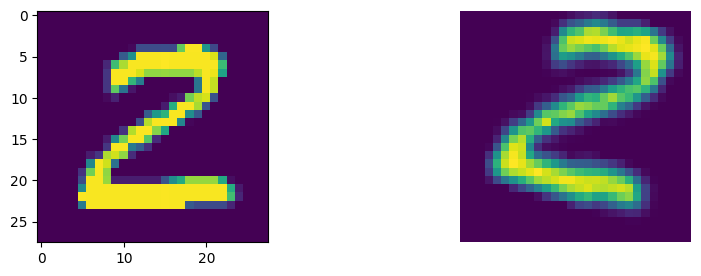

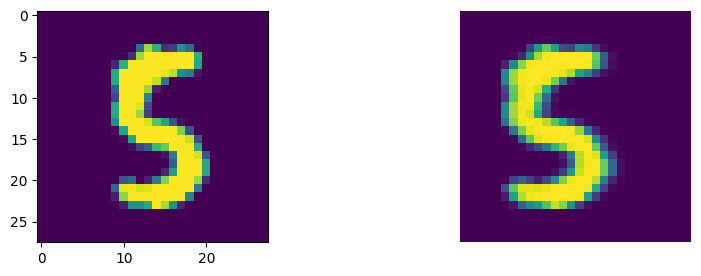

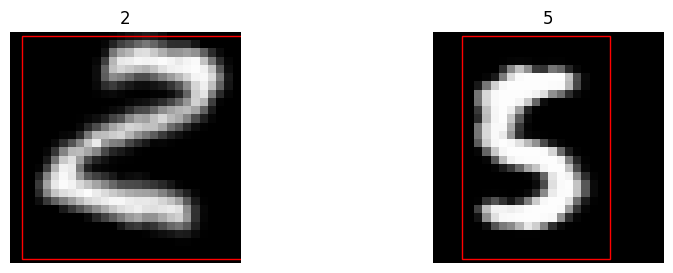

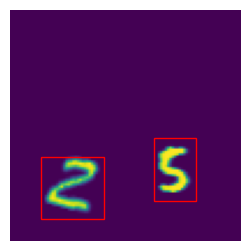

current bbox is {'x_min': 13, 'x_max': np.int64(40), 'y_min': 63, 'y_max': np.int64(90), 'x_center': 27, 'y_center': 76, 'width': np.int64(27), 'height': np.int64(27), 'class_value': np.uint8(2)}
mapped prediction is [ 1. 27. 76. 27. 27.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
current bbox is {'x_min': 62, 'x_max': np.int64(80), 'y_min': 55, 'y_max': np.int64(82), 'x_center': 74, 'y_center': 68, 'width': np.int64(18), 'height': np.int64(27), 'class_value': np.uint8(5)}
mapped prediction is [ 1. 74. 68. 18. 27.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [7]:
sample_indices = get_sample_indices(x_train, 1)
test_x = x_train[sample_indices]
test_y = y_train[sample_indices]
canvas, prediction = generate_training_example(test_x,test_y,debug=True)

# Training & Evaluation

# Test Data Validation